In [ ]:
# ================================================
# 0. SETUP
# ================================================
!pip install biopython xgboost shap scikit-learn umap-learn

import numpy as np
import pandas as pd
import random
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import umap
from numpy.random import default_rng

rng = default_rng(42)

print("Environment ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.9 MB/s eta 0:00:00
Environment ready.


In [ ]:
# ================================================
# 1. DATA SIMULATION (Replace with ATUM data later)
# ================================================

# Simulate N antibody sequences with CDR-like regions
def random_protein_seq(n=120):
    aas = list("ACDEFGHIKLMNPQRSTVWY")
    return ''.join(rng.choice(aas, size=n))

def simulate_expression_data(N=1000):
    seqs = [random_protein_seq() for _ in range(N)]

    # Simulate "true" biological effects:
    # positive effect: hydrophobicity of certain region
    # negative effect: cysteine count, glycosylation sequons
    hydros = []
    cysts = []
    glyc = []
    for s in seqs:
        pa = ProteinAnalysis(s)
        hydros.append(pa.gravy())
        cysts.append(s.count("C"))
        glyc.append(sum(s[i:i+3] == "NXS" for i in range(len(s)-2)))

    # logistic model for success probability
    logits = (
        1.5 * np.array(hydros)
        - 0.8 * np.array(cysts)
        - 1.2 * np.array(glyc)
        + rng.normal(0, 0.5, size=N)
    )
    probs = 1 / (1 + np.exp(-logits))
    labels = rng.binomial(1, probs)

    df = pd.DataFrame({
        "sequence": seqs,
        "hydrophobicity_true": hydros,
        "cys_count_true": cysts,
        "glyco_true": glyc,
        "success": labels
    })
    return df

df = simulate_expression_data(800)
df.head()


,sequence,hydrophobicity_true,cys_count_true,glyco_true,success
0,CSQKKVCQFCMYRSRSMDTLMIEWSPKTMKLFCNVCVTGPESRICY...,-0.459167,8,0,0
1,KQQLVNCSNPNNCNSHPAHKYFGKYVAFTCVGWGKQDNMSYQKKKT...,-0.968333,7,0,0
2,DNCPPCSKSAELEHQDQDENSEGWYNKHPNGAEYKLLSCCGLQLKW...,-0.945833,5,0,0
3,TVFVDMLHASHQKIVCRRIGAWWFADCTVEREINRVAEGHYSHYLM...,-0.905833,4,0,0
4,GTGSLFHMSPWVSPGKDIWKDQYVGLMFGFYRTTYDVCLNIDETHH...,-0.410833,6,0,0


In [ ]:
# ================================================
# 2. CDR EXTRACTION (Placeholder)
# ================================================
# TODO:
# - Replace with ANARCI numbering pipeline once ATUM provides antibody sequences.
# - For now, use whole sequence as a proxy for feature building.

def extract_cdr_regions(seq):
    # Placeholder: in real pipeline, use ANARCI or IMGT numbering.
    L = len(seq)
    return {
        "cdr_h1": seq[10:20],
        "cdr_h2": seq[40:52],
        "cdr_h3": seq[80:100],
        "framework": seq[:10] + seq[20:40] + seq[52:80] + seq[100:]
    }

# Test
extract_cdr_regions(df.sequence.iloc[0])


{'cdr_h1': 'MYRSRSMDTL',
 'cdr_h2': 'ESRICYKVQSSE',
 'cdr_h3': 'WKETPRCHSTKTTIVGFQPD',
 'framework': 'CSQKKVCQFCMIEWSPKTMKLFCNVCVTGPILLAMERQWRIYKHWICLSELDQLHFNQTETASSSQLRGSNLMNADFD'}

In [ ]:
# ================================================
# 3. FEATURE EXTRACTION
# ================================================

hydro_scale = {
    'A':1.8,'C':2.5,'D':-3.5,'E':-3.5,'F':2.8,'G':-0.4,'H':-3.2,'I':4.5,'K':-3.9,
    'L':3.8,'M':1.9,'N':-3.5,'P':-1.6,'Q':-3.5,'R':-4.5,'S':-0.8,'T':-0.7,'V':4.2,'W':-0.9,'Y':-1.3
}

def aa_physchem_summary(seq):
    pa = ProteinAnalysis(seq)
    return {
        "aa_len": len(seq),
        "aa_aromaticity": pa.aromaticity(),
        "aa_instability": pa.instability_index(),
        "aa_charge": pa.charge_at_pH(7.4),
        "aa_isoelectric": pa.isoelectric_point(),
        "aa_hydrophobicity": np.mean([hydro_scale.get(a,0) for a in seq])
    }

# K-mer 3-mer vector
import itertools

kmers = [''.join(p) for p in itertools.product("ACDEFGHIKLMNPQRSTVWY", repeat=2)]  # 2-mers (400 dims)
kmer_to_idx = {k:i for i,k in enumerate(kmers)}

def kmer_embedding(seq, k=2):
    vec = np.zeros(len(kmers))
    for i in range(len(seq)-k+1):
        km = seq[i:i+k]
        if km in kmer_to_idx:
            vec[kmer_to_idx[km]] += 1
    if vec.sum() > 0:
        vec = vec / vec.sum()
    return vec

# manufacturability flags
def manufacturability_flags(seq):
    return {
        "cys_count": seq.count("C"),
        "glyco_motif": sum(seq[i:i+3] == "NXS" for i in range(len(seq)-2)),
        "proline_count": seq.count("P")
    }



In [ ]:
# ================================================
# 4. APPLY FEATURE FACTORY
# ================================================

feature_rows = []
kmer_rows = []

for seq in df.sequence:
    feats = aa_physchem_summary(seq)
    feats.update(manufacturability_flags(seq))
    feature_rows.append(feats)

    k_emb = kmer_embedding(seq, k=2)
    kmer_rows.append(k_emb)

F_basic = pd.DataFrame(feature_rows)
F_kmer = pd.DataFrame(kmer_rows)

X = pd.concat([F_basic.reset_index(drop=True),
               F_kmer.reset_index(drop=True)], axis=1)
y = df.success.values

X.shape, y.shape


((800, 409), (800,))

In [ ]:
# ================================================
# 5. MODELING
# ================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probs)
auc

np.float64(0.7525252525252526)

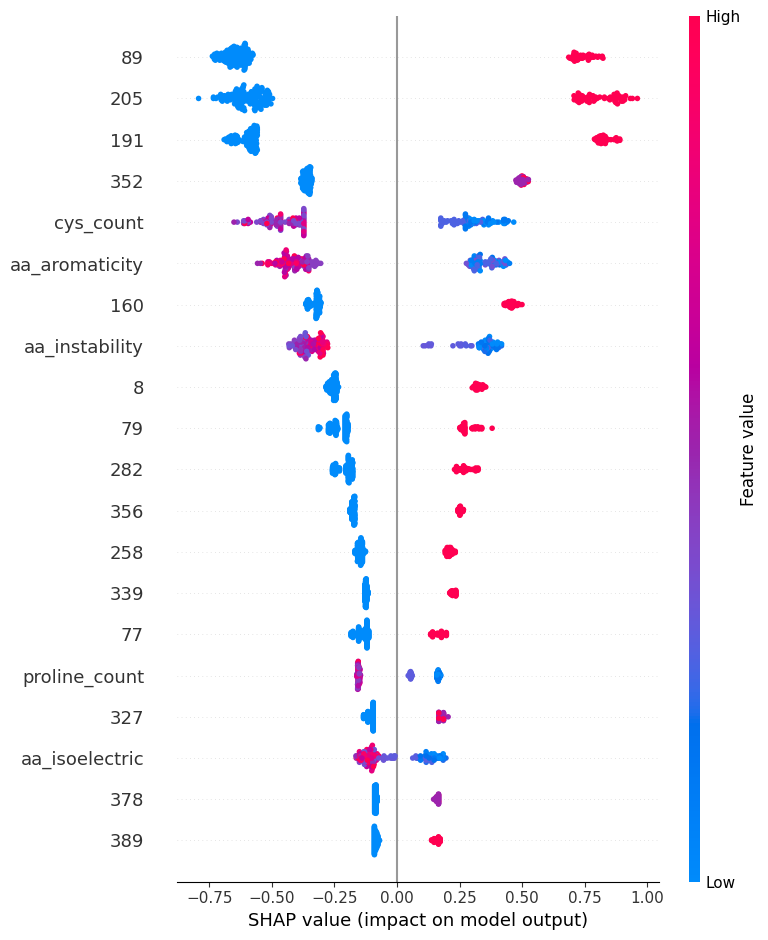

In [ ]:
# ================================================
# 6. SHAP INTERPRETATION
# ================================================
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global summary
shap.summary_plot(shap_values, X_test)

# One candidate explanation
i = 3
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:])


In [ ]:
# ================================================
# 7. RANK CANDIDATES
# ================================================
df_test = df.iloc[X_test.index].copy()
df_test["pred_success"] = probs

top100 = df_test.sort_values("pred_success", ascending=False).head(100)
top100[["sequence","pred_success"]].head()


,sequence,pred_success
656,KGREEHMSRTLQISSKDFNHCPSWFEEQIWREDCEKACSNLNWVSE...,0.230554
571,RHLPLRQTSYGESGETCSRQCAIEVFPYGICQKGVSAVVPLWRPVL...,0.042775
509,IKWLNMQNPSAQMRGMCGSGRSPTHFKDTKHTESRDCEHDARFLCY...,0.037302
421,DADFQNGMYQAMGLDIDEMSTQVIWCPPDPLYNCRCNRGYCVKSIW...,0.031268
793,VCNYRYLKLPWMDLFESFHKCMERQEQVDFFCWGWWYKLIWCTAPE...,0.028205


In [ ]:
# ================================================
# 8. DIVERSITY FILTERING
# ================================================
from sklearn.metrics import pairwise_distances

# Get embeddings (UMAP for dimensionality reduction)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1)
emb = reducer.fit_transform(F_kmer.loc[top100.index])

selected = [0]
for _ in range(20):  # pick 20 diverse sequences
    remaining = list(set(range(len(emb))) - set(selected))
    dists = pairwise_distances(emb[remaining], emb[selected]).min(axis=1)
    next_idx = remaining[dists.argmax()]
    selected.append(next_idx)

diverse_top20 = top100.iloc[selected]
diverse_top20.head()

,sequence,hydrophobicity_true,cys_count_true,glyco_true,success,pred_success
656,KGREEHMSRTLQISSKDFNHCPSWFEEQIWREDCEKACSNLNWVSE...,-0.690833,8,0,0,0.230554
82,ALYQNIAERPVTVHRVCDFIFCPRIWRNAKSNVSYKETTHCHLVIS...,-0.078333,10,0,0,0.008281
21,KAKSIERSYWRFTEGVGYLTGHQMGGFMEKNTEWWHPYSVYTTYQF...,-0.430833,4,0,0,0.004048
671,ELDYNWHPMLHHPFWSCKIEDQPWQHLQKFSCKMERGAPYFRVMDY...,-0.589167,5,0,0,0.001066
204,GEFNYQVFNHLALVCIDITIRYMMTMWMFDCMLEMMKQKRAGTAPK...,-0.210833,9,0,0,0.001267


In [ ]:
# ================================================
# 9. EXPORT RESULTS
# ================================================
top100.to_csv("top100_candidates.csv", index=False)
diverse_top20.to_csv("diverse_top20_candidates.csv", index=False)

print("Exported: top100 and diverse top20 candidate lists.")


Exported: top100 and diverse top20 candidate lists.
